In [69]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import re

In [70]:
pd.options.display.max_colwidth = 200

### Load and inspect data

In [71]:
loan_data_df = pd.read_csv('loan.csv', low_memory=False)
column_desc_df = pd.read_excel('Data_Dictionary.xlsx')
loan_data_df.info()
before_cols = len(loan_data_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


### Finding Columns having all Null or 90% Null data

#### Columns having all Null

In [72]:
all_empty_cols= loan_data_df.columns[loan_data_df.isna().all()].tolist()
print(f"Total number of all empty columns are : {len(all_empty_cols)}\n")
print(all_empty_cols)

Total number of all empty columns are : 54

['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mor

 #### All Columns having 90% or more Null data

 **Note:** Following list will be the superset of previous list.

In [73]:
atleast_90pct_empty = loan_data_df.columns[~(loan_data_df.isnull().sum(axis=0) <= loan_data_df.shape[0] * 0.9)].tolist()
print(f"Columns with atleast 90% of empty columns are : {len(atleast_90pct_empty)}\n")
print(atleast_90pct_empty)

Columns with atleast 90% of empty columns are : 56

['mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'perce

### Data Cleanup

#### Delete all or 90% empty columns

In [74]:
# Remove all columns with null values
loan_data_df = loan_data_df.dropna(axis=1, how='all')
# Remove all columns with 90% null values
loan_data_df = loan_data_df.loc[:, (loan_data_df.isnull().sum(axis=0) <= loan_data_df.shape[0] * 0.9)]

#### Remove columns which have constant as a value. 
These will become metadata for the dataset because the dataset has only one value for them.
eg. all values in column: pymnt_plan are `n`.

In [75]:
constant_cols_dict = { c : loan_data_df[c].value_counts().index[0] for c in loan_data_df.columns if loan_data_df[c].value_counts().count() == 1} 

print(f"Columns having constant values: {constant_cols_dict}\n")

print(f"Columns to be removed : {constant_cols_dict.keys()}\n")

loan_data_df.drop(columns=constant_cols_dict.keys(), inplace=True) 


Columns having constant values: {'pymnt_plan': 'n', 'initial_list_status': 'f', 'collections_12_mths_ex_med': 0.0, 'policy_code': 1, 'application_type': 'INDIVIDUAL', 'acc_now_delinq': 0, 'chargeoff_within_12_mths': 0.0, 'delinq_amnt': 0, 'tax_liens': 0.0}

Columns to be removed : dict_keys(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'])



#### Inspecting data in columns, 
Some columns can be removed since they don't give much use to the analysis

In [76]:
print("desc, purpose, title are similar - title and desc seem to be human added and have more distinct values. Purpose has a finite list and it alone can be looked at and drop desc and title.")
print("\n-------title-----------\n", loan_data_df.title.value_counts().index, 
      # "\n-------desc----------\n", loan_data_df.desc.value_counts().index, # Too much data. skipping print
      "\n-------purpose-----------\n", loan_data_df.purpose.value_counts().index)
cols_to_drop = ['title', 'desc']
print("url column has external url for lending club, and not much use to analysys")
print(loan_data_df.url.head())
cols_to_drop.append('url')
loan_data_df.drop(columns=cols_to_drop, inplace=True) 

desc, purpose, title are similar - title and desc seem to be human added and have more distinct values. Purpose has a finite list and it alone can be looked at and drop desc and title.

-------title-----------
 Index(['Debt Consolidation', 'Debt Consolidation Loan', 'Personal Loan',
       'Consolidation', 'debt consolidation', 'Home Improvement',
       'Credit Card Consolidation', 'Debt consolidation',
       'Small Business Loan', 'Credit Card Loan',
       ...
       'Stav', 'Florida Vacation 2011', 'Ninja zx6', 'Pay off Masters Degree',
       'CREDIT CARD CONSOLIDATION LOAN 01', 'your rate is better than my rate',
       'Concession Trailer', 'gregs', 'EZover', 'JAL Loan'],
      dtype='object', length=19615) 
-------purpose-----------
 Index(['debt_consolidation', 'credit_card', 'other', 'home_improvement',
       'major_purchase', 'small_business', 'car', 'wedding', 'medical',
       'moving', 'vacation', 'house', 'educational', 'renewable_energy'],
      dtype='object')
url co

#### Dataset after removed columns

In [77]:
print(f"The no. columns are reduced from {before_cols} to {len(loan_data_df.columns)}")

The no. columns are reduced from 111 to 43


In [78]:
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39717 non-null  int64  
 1   member_id                39717 non-null  int64  
 2   loan_amnt                39717 non-null  int64  
 3   funded_amnt              39717 non-null  int64  
 4   funded_amnt_inv          39717 non-null  float64
 5   term                     39717 non-null  object 
 6   int_rate                 39717 non-null  object 
 7   installment              39717 non-null  float64
 8   grade                    39717 non-null  object 
 9   sub_grade                39717 non-null  object 
 10  emp_title                37258 non-null  object 
 11  emp_length               38642 non-null  object 
 12  home_ownership           39717 non-null  object 
 13  annual_inc               39717 non-null  float64
 14  verification_status   

In [79]:
loan_data_df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0


#### Convert the columns to correct datatypes

In [88]:
from datetime import date, datetime
def convert_emp_length(l):
    if pd.isna(l):
        return np.nan
    elif l == '< 1 year':
        return 0
    elif l == '10+ years':
        return 10
    else:
        return int(str(l)[0])

def convert_period_to_date(p):
    if type(p) == date:
        return p
    period_parts = p.split('-')
    return date( int(f"19{period_parts[1]}" if int(period_parts[1]) > 30 else f"20{period_parts[1]}") ,  datetime.strptime(period_parts[0],'%b').month, 1) 

In [91]:
# numbers
loan_data_df.term               = loan_data_df.term.apply(lambda x: int(str(x)[:3]))
loan_data_df.emp_length         = loan_data_df.emp_length.apply(convert_emp_length) 
# percentages
loan_data_df.int_rate           = loan_data_df.int_rate.apply(lambda x: float(str(x)[:-1])/100)
loan_data_df.revol_util         = loan_data_df.revol_util.apply(lambda x: (float(str(x)[:-1])/100) if str(x) != 'nan' else x)
# dates
loan_data_df.issue_d            = pd.to_datetime(loan_data_df.issue_d, format='%b-%y')
loan_data_df.last_pymnt_d       = pd.to_datetime(loan_data_df.last_pymnt_d, format='%b-%y')
loan_data_df.last_credit_pull_d = pd.to_datetime(loan_data_df.last_credit_pull_d, format='%b-%y')
# only years 69-99 will be added with 20th century(19xx) padding in python
# ref: https://docs.python.org/3/library/time.html#:~:text=values%2069%E2%80%9399%20are%20mapped%20to%201969%E2%80%931999%2C%20and%20values%200%E2%80%9368%20are%20mapped%20to%202000%E2%80%932068.
loan_data_df.earliest_cr_line   = loan_data_df.earliest_cr_line.apply(convert_period_to_date) 


In [92]:
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       39717 non-null  int64         
 1   member_id                39717 non-null  int64         
 2   loan_amnt                39717 non-null  int64         
 3   funded_amnt              39717 non-null  int64         
 4   funded_amnt_inv          39717 non-null  float64       
 5   term                     39717 non-null  int64         
 6   int_rate                 39717 non-null  float64       
 7   installment              39717 non-null  float64       
 8   grade                    39717 non-null  object        
 9   sub_grade                39717 non-null  object        
 10  emp_title                37258 non-null  object        
 11  emp_length               38642 non-null  float64       
 12  home_ownership           39717 n

#### Remove/add value to rows with null values in certain columns

In [93]:
loan_data_df.isna().sum()[loan_data_df.isna().sum() > 0]

emp_title                  2459
emp_length                 1075
mths_since_last_delinq    25682
revol_util                   50
last_pymnt_d                 71
last_credit_pull_d            2
pub_rec_bankruptcies        697
dtype: int64

Remove rows with very few (<100) NaNs

In [94]:
cols_with_few_nan_rows = list(loan_data_df.isna().sum()[(loan_data_df.isna().sum() < 700) & (loan_data_df.isna().sum() > 0)].index)
for col in cols_with_few_nan_rows:
    loan_data_df.drop(loan_data_df[loan_data_df[col].isna()].index, inplace=True)

The borrowers who have not been delinquated forever, we are setting higher value than the max avialable in dataset. 

In [96]:
loan_data_df.mths_since_last_delinq.fillna(value=1000, inplace=True)
loan_data_df.mths_since_last_delinq.value_counts()

1000.0    25594
30.0        245
15.0        241
23.0        241
24.0        235
          ...  
89.0          1
107.0         1
85.0          1
97.0          1
95.0          1
Name: mths_since_last_delinq, Length: 96, dtype: int64

The borrowers who do not have employment length are missing values. We are deleting those rows.

In [97]:
loan_data_df.drop(loan_data_df[loan_data_df['emp_length'].isna()].index, inplace=True)

In [98]:
print("Columns with non-zero NaN values left:")
loan_data_df.isna().sum()[loan_data_df.isna().sum() > 0]

Columns with non-zero NaN values left:


emp_title    1393
dtype: int64

### Final Data Dictionary

In [101]:
column_desc_df = column_desc_df[column_desc_df.LoanStatNew.isin(loan_data_df.columns)]
column_desc_df.reset_index(inplace=True)

In [102]:
column_desc_df.loc[:, ['LoanStatNew', 'Description']]

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,collection_recovery_fee,post charge off collection fee
3,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
4,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly inc..."
5,earliest_cr_line,The month the borrower's earliest reported credit line was opened
6,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
7,emp_title,The job title supplied by the Borrower when applying for the loan.*
8,funded_amnt,The total amount committed to that loan at that point in time.
9,funded_amnt_inv,The total amount committed by investors for that loan at that point in time.


### Find and remove outliers

[Annual Income] Rows <98%ile(189000.00): 37075
[Annual Income] Rows < 2M$: 37833
[Loan Amount] Rows <98%ile(32000.00): 37065
LoanAmount < 98%ile and Annual income < 98%ile: num of rows: 36409
 total rows: 37833


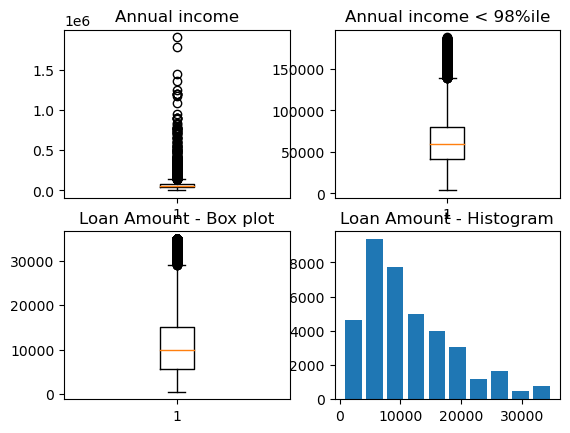

In [174]:
plt.subplot(2, 2, 1)
plt.subplot(2, 2, 1).set_title('Annual income')
plt.boxplot(loan_data_df.annual_inc)

plt.subplot(2, 2, 2)
plt.subplot(2, 2, 2).set_title('Annual income < 98%ile')
plt.boxplot(loan_data_df.annual_inc[loan_data_df.annual_inc < loan_data_df.annual_inc.quantile(0.98)])


print("[Annual Income] Rows <98%%ile(%.2f): %d" % (loan_data_df.annual_inc.quantile(0.98), (loan_data_df.annual_inc < loan_data_df.annual_inc.quantile(0.98)).sum()))
print("[Annual Income] Rows < 2M$: %d" % ((loan_data_df.annual_inc < 2000000).sum()))

plt.subplot(2, 2, 3)
plt.subplot(2, 2, 3).set_title('Loan Amount - Box plot')
plt.boxplot(loan_data_df.loan_amnt)

plt.subplot(2, 2, 4)
plt.subplot(2, 2, 4).set_title('Loan Amount - Histogram')
plt.hist(loan_data_df.loan_amnt, rwidth=0.8)

print("[Loan Amount] Rows <98%%ile(%.2f): %d" % (loan_data_df.loan_amnt.quantile(0.98), (loan_data_df.loan_amnt < loan_data_df.loan_amnt.quantile(0.98)).sum()))

print("LoanAmount < 98%%ile and Annual income < 98%%ile: num of rows: %d" % (loan_data_df[(loan_data_df.loan_amnt < loan_data_df.loan_amnt.quantile(0.98)) &
                                                                                        (loan_data_df.annual_inc < loan_data_df.annual_inc.quantile(0.98))].shape[0]))
print(f" total rows: {loan_data_df.shape[0]}")

plt.show()

There is a clear gap in annual income for entries above 2M\\$ with just two entries at 4M\\$ and 6M\\$ respectively. We can ignore those
After removing rows that have outliers from above, we get below:

In [166]:
loan_data_df = loan_data_df[loan_data_df.annual_inc < 2000000]

### Analyze columns of interest

80     35000
128    35000
185    35000
268    35000
276    35000
306    35000
336    35000
387    35000
431    35000
496    35000
Name: loan_amnt, dtype: int64